In [1]:
import numpy as np # linear algebra
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [3]:
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

In [4]:
def rmse(model, x, y):
    y_pred = model.predict(x)
    mse = mean_squared_error(y_pred, y)
    rmse = np.sqrt(mse)
    return(rmse)

In [5]:
import data_pipeline as dp
from data_pipeline.data_preprocessor import PreProcessor as PP
# load train set, test set

pp = PP("total_data.csv")

x_train, y_train, x_test, y_test = pp.process()

pp_d = PP("final_data.csv")
# for conti / discrete comparing
x_train_d, y_train_d, x_test_d, y_test_d = pp_d.process()

y_train

5407    -0.307448
15919    0.125396
17827    0.146596
11694   -0.861599
3292     0.928132
           ...   
11039   -0.938133
17006    0.094725
20766    0.932067
19440    0.324292
15454   -0.112337
Name: latency, Length: 17014, dtype: float64

In [6]:
# -----------------------------------------------------------------

In [7]:
# kernel Ridge regression

# KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5) #kernel = 'rbf' , 'sigmoid' 

In [8]:
# Gradient Boosting Regression

GBoost = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.1,
                                   max_depth=3, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [9]:
# LGB Regressor

model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=500,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [10]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1"


In [11]:
# XGBoost Algorithm (without GridSearch)

model_xgb = xgb.XGBRegressor(colsample_bytree=0.4, gamma=0.05, 
                             learning_rate=0.12, max_depth=4, 
                             min_child_weight=1.5, n_estimators=500,
                             reg_alpha=0.5, reg_lambda=0.7, tree_method="gpu_hist",
                             subsample=0.5, random_state =3, nthread = -1)

In [12]:
# Random Forest Regressor with GridSearch


regr = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=150, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=90, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

#grid_search.best_estimator_

In [13]:
# -----------------------------------------------------

In [14]:
model_xgb.fit(x_train, y_train)
model_lgb.fit(x_train, y_train)
GBoost.fit(x_train,y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='huber',
                          max_depth=3, max_features='sqrt', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=15, min_samples_split=10,
                          min_weight_fraction_leaf=0.0, n_estimators=1000,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=5, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [15]:
# Gradient Boosting score
score = rmse(GBoost, x_train, y_train)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1453 (0.0000)



In [16]:
# Light GBM score
score = rmse(model_lgb, x_train, y_train)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LGBM score: 0.1735 (0.0000)



In [17]:
# XGBoost score
score = rmse(model_xgb, x_train, y_train)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.1093 (0.0000)



In [18]:
from joblib import load
def inverse_latency(X):
    robust, quantile = load("robust.pkl"), load("quantile.pkl")
    if isinstance(X, pd.Series):
        X = X.values.reshape(-1, 1)
    else:
        X = X.reshape(-1, 1)
    return robust.inverse_transform(quantile.inverse_transform(X)).reshape(-1)

In [19]:
#define a rmsle evaluation function

# def rmsle(y, y_pred): 
#    return np.sqrt(mean_squared_error(y, y_pred))

def rmse_with_inverse(model, x_test, y_test):
    y_pred = model.predict(x_test)
    y_test, y_pred = inverse_latency(y_test), inverse_latency(y_pred)
    return np.sqrt(mean_squared_error(y_test, y_pred))

In [20]:
print("Gradient Boosting rmse: {}".format(rmse_with_inverse(GBoost, x_test, y_test)))
print("LGBM rmse : {}".format(rmse_with_inverse(model_lgb, x_test, y_test)))
print("Xgboost rmse : {}".format(rmse_with_inverse(model_xgb, x_test, y_test)))

Gradient Boosting rmse: 27905.37473121186
LGBM rmse : 19858.966771066112
Xgboost rmse : 20920.20948167078


In [21]:
print("Gradient Boosting rmse: {}".format(rmse_with_inverse(GBoost, x_test_d, y_test_d)))
print("LGBM rmse : {}".format(rmse_with_inverse(model_lgb, x_test_d, y_test_d)))
print("Xgboost rmse : {}".format(rmse_with_inverse(model_xgb, x_test_d, y_test_d)))

Gradient Boosting rmse: 172455.46557490237
LGBM rmse : 172102.34649883688
Xgboost rmse : 177775.6328543226


In [22]:
def erratio_winverse(model, x_test, y_test):
    y_pred = model.predict(x_test)
    y_test, y_pred = np.array(inverse_latency(y_test)), np.array(inverse_latency(y_pred))
    err = y_pred - y_test
    ratio = err / y_test * 100
    return ratio.mean()

In [23]:
print("Gradient Boosting error ratio : {}".format(erratio_winverse(GBoost, x_test, y_test)))
print("LGBM rmse error ratio : {}".format(erratio_winverse(model_lgb, x_test, y_test)))
print("Xgboost error ratio : {}".format(erratio_winverse(model_xgb, x_test, y_test)))

Gradient Boosting error ratio : 0.038749586553592556
LGBM rmse error ratio : -0.1741135084542859
Xgboost error ratio : -0.316624848821414


In [24]:
print("Gradient Boosting error ratio : {}".format(erratio_winverse(GBoost, x_test_d, y_test_d)))
print("LGBM rmse error ratio : {}".format(erratio_winverse(model_lgb, x_test_d, y_test_d)))
print("Xgboost error ratio : {}".format(erratio_winverse(model_xgb, x_test_d, y_test_d)))

Gradient Boosting error ratio : 33.32293129645649
LGBM rmse error ratio : 33.61662103990329
Xgboost error ratio : 32.19252447673446


# XGBoost

In [25]:
# XGBoost score with discrete
score = rmse(model_xgb, x_test_d, y_test_d)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.9763 (0.0000)



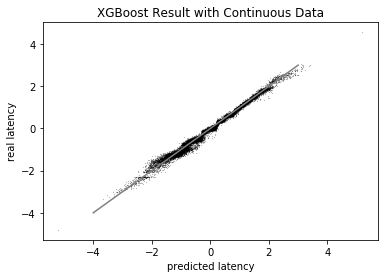

<Figure size 432x288 with 0 Axes>

In [26]:
xgb_train_pred = model_xgb.predict(x_train)

x = np.arange(-4,4) 
y = x

plt.plot(x, y, color = 'gray')
plt.scatter(y_train, xgb_train_pred, s=0.01, color='black')
plt.xlabel('predicted latency')
plt.ylabel('real latency')
plt.title('XGBoost Result with Continuous Data')
plt.show()
plt.savefig('xgboost_result.pdf', format='pdf')

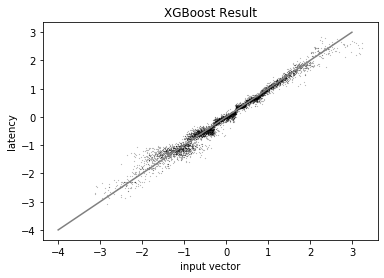

In [27]:
xgb_pred = model_xgb.predict(x_test)

plt.plot(x, y, color = 'gray')
plt.scatter(y_test, xgb_pred, s=0.01, color='black')
plt.xlabel('input vector')
plt.ylabel('latency')
plt.title('XGBoost Result')
plt.show()

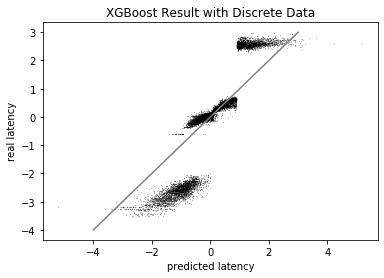

<Figure size 432x288 with 0 Axes>

In [28]:
xgb_pred_d = model_xgb.predict(x_train_d)

plt.plot(x, y, color = 'gray')
plt.scatter(y_train_d, xgb_pred_d, s=0.01, color='black')
plt.xlabel('predicted latency')
plt.ylabel('real latency')
plt.title('XGBoost Result with Discrete Data')
plt.show()
plt.savefig('xgboost_result_with_d.pdf', format='pdf')

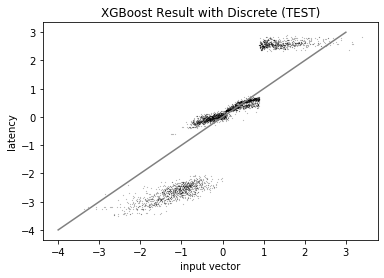

In [29]:
# comparing discrete

xgb_pred_d = model_xgb.predict(x_test_d)

plt.plot(x, y, color = 'gray')
plt.scatter(y_test_d, xgb_pred_d, s=0.01, color='black')
plt.xlabel('input vector')
plt.ylabel('latency')
plt.title('XGBoost Result with Discrete (TEST)')
plt.show()

In [30]:
print(model_xgb.feature_importances_)

[0.04984321 0.06780335 0.27637684 0.00325415 0.00440212 0.00188467
 0.00130838 0.00164252 0.00454694 0.00469849 0.00255442 0.0030103
 0.00216178 0.01016958 0.00139898 0.00227911 0.00858572 0.00600359
 0.00169467 0.00142382 0.00887458 0.00333801 0.00309609 0.00372266
 0.0287865  0.00168787 0.00287622 0.00265006 0.00144189 0.00507597
 0.0017315  0.0012861  0.00567953 0.00157519 0.00342177 0.00194003
 0.00208488 0.00249445 0.00328027 0.00723935 0.00426988 0.00219355
 0.00188834 0.00127319 0.00612557 0.00146067 0.0083668  0.00269738
 0.00685633 0.00260083 0.00427404 0.0016183  0.0039288  0.00265798
 0.00592328 0.00137083 0.00305544 0.00290379 0.00484388 0.00270564
 0.00177881 0.00154704 0.00261291 0.0017068  0.00283576 0.00677649
 0.00815958 0.00261189 0.00175309 0.00267908 0.00342041 0.00209892
 0.0050645  0.00272813 0.00334764 0.00324223 0.00259504 0.00147908
 0.00204776 0.01087154 0.00470464 0.00228055 0.00364187 0.00220987
 0.00445322 0.00186654 0.00434688 0.00420014 0.00143363 0.00417

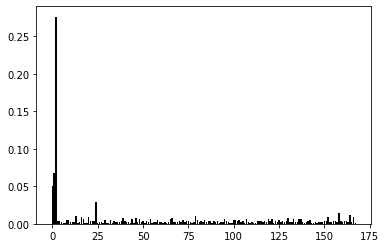

In [31]:
plt.bar(range(len(model_xgb.feature_importances_)), model_xgb.feature_importances_, color='black')
plt.savefig('feature_importance_graph.pdf', format='pdf')
plt.show()


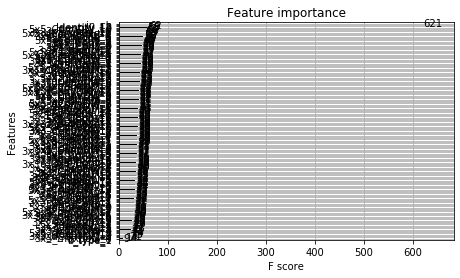

<Figure size 432x288 with 0 Axes>

In [32]:
from xgboost import plot_importance
plot_importance(model_xgb, color='black')
plt.show()
plt.savefig('feature_importance_all.pdf', format='pdf')

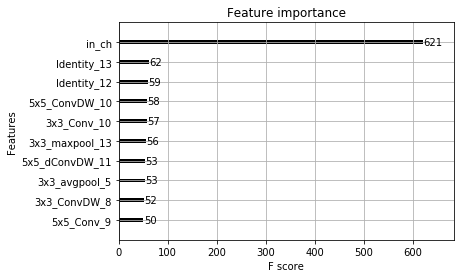

<Figure size 432x288 with 0 Axes>

In [33]:
plot_importance(model_xgb, max_num_features=10, color='black')
plt.show()
plt.savefig('feature_importance_top10.pdf', format='pdf')

# Gradient Boost

In [34]:
# Gradient Boosting score
score = rmse(GBoost, x_test_d, y_test_d)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.9427 (0.0000)



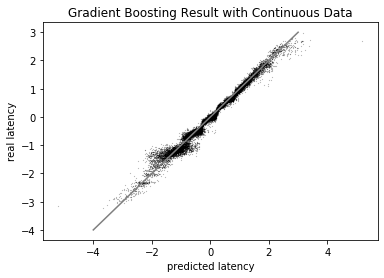

<Figure size 432x288 with 0 Axes>

In [35]:
gb_pred = GBoost.predict(x_train)

plt.plot(x, y, color = 'gray')
plt.scatter(y_train, gb_pred, s=0.01, color='black')
plt.xlabel('predicted latency')
plt.ylabel('real latency')
plt.title('Gradient Boosting Result with Continuous Data')
plt.show()
plt.savefig('gb_result.pdf', format='pdf')

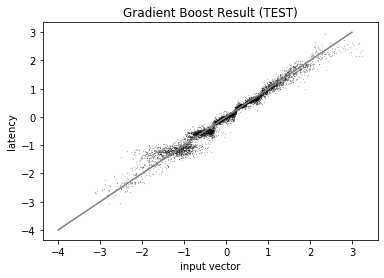

In [36]:
gb_pred = GBoost.predict(x_test)

plt.plot(x, y, color = 'gray')
plt.scatter(y_test, gb_pred, s=0.01, color='black')
plt.xlabel('input vector')
plt.ylabel('latency')
plt.title('Gradient Boost Result (TEST)')
plt.show()

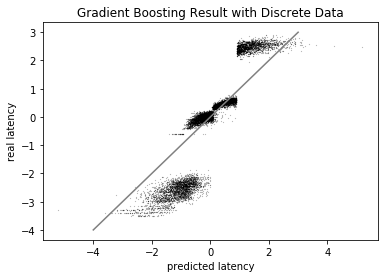

<Figure size 432x288 with 0 Axes>

In [37]:
gb_pred = GBoost.predict(x_train_d)

plt.plot(x, y, color = 'gray')
plt.scatter(y_train_d, gb_pred, s=0.01, color='black')
plt.xlabel('predicted latency')
plt.ylabel('real latency')
plt.title('Gradient Boosting Result with Discrete Data')
plt.show()
plt.savefig('gb_result.pdf', format='pdf')

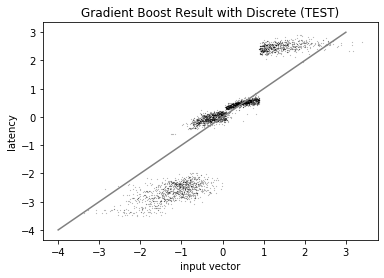

In [38]:
gb_pred = GBoost.predict(x_test_d)

plt.plot(x, y, color = 'gray')
plt.scatter(y_test_d, gb_pred, s=0.01, color='black')
plt.xlabel('input vector')
plt.ylabel('latency')
plt.title('Gradient Boost Result with Discrete (TEST)')
plt.show()

# Light GBM

In [39]:
# Light GBM score with discrete
score = rmse(model_lgb, x_test_d, y_test_d)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LGBM score: 0.9371 (0.0000)



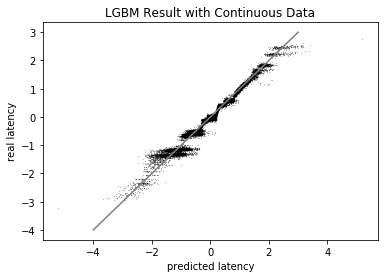

<Figure size 432x288 with 0 Axes>

In [40]:
lgb_pred = model_lgb.predict(x_train)

plt.plot(x, y, color = 'gray')
plt.scatter(y_train, lgb_pred, s=0.01, color='black')
plt.xlabel('predicted latency')
plt.ylabel('real latency')
plt.title('LGBM Result with Continuous Data')
plt.show()
plt.savefig('lgbm_result.pdf', format='pdf')

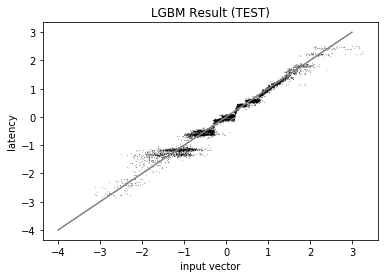

In [41]:
lgb_pred = model_lgb.predict(x_test)

plt.plot(x, y, color = 'gray')
plt.scatter(y_test, lgb_pred, s=0.01, color='black')
plt.xlabel('input vector')
plt.ylabel('latency')
plt.title('LGBM Result (TEST)')
plt.show()

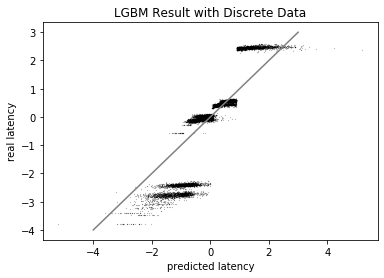

<Figure size 432x288 with 0 Axes>

In [42]:
lgb_pred = model_lgb.predict(x_train_d)

plt.plot(x, y, color = 'gray')
plt.scatter(y_train_d, lgb_pred, s=0.01, color='black')
plt.xlabel('predicted latency')
plt.ylabel('real latency')
plt.title('LGBM Result with Discrete Data')
plt.show()
plt.savefig('lgbm_result_with_d.pdf', format='pdf')

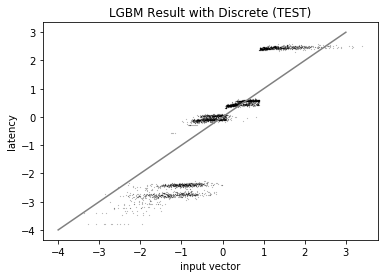

In [43]:
lgb_pred = model_lgb.predict(x_test_d)

plt.plot(x, y, color = 'gray')
plt.scatter(y_test_d, lgb_pred, s=0.01, color='black')
plt.xlabel('input vector')
plt.ylabel('latency')
plt.title('LGBM Result with Discrete (TEST)')
plt.show()

In [44]:
# ISSUE : 시사하는 바?
# 일단은 30%니까 ㄱㅊ지 않을까?